In [1]:
# Homework 6 Template
# G. Besla & R. Li

In [2]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from CenterOfMass2 import CenterOfMass



In [3]:
def OrbitCOM(galaxy, start, end, n):
    """function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
          
    outputs: 
    """
    
    # compose the filename for output
    fileout = f"Orbit_{galaxy}.txt"
    #  set tolerance and VolDec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for VolDec
    delta = 0.1 
    if galaxy == "M33": 
        volDec = 4
    else: 
        volDec = 2 
    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, n)
    if len(snap_ids) == 0:
        print("No snapshots to analyze")
        return None
    
    # initialize the array for orbital info: t, x, y, z, vx, vy, vz of COM
    orbit = np.zeros((len(snap_ids), 7))
    
    # a for loop 
    for i, snap_id in enumerate(snap_ids): # loop over files
        
        # compose the data filename (be careful about the folder)
        ilbl = '000' + str(snap_id)
        ilbl = ilbl[-3:]
        filename=f"../../Data/VLowRes/{galaxy}/{galaxy}_"+ ilbl + '.txt'
        # Initialize an instance of CenterOfMass class, using disk particles
        COM = CenterOfMass(filename, 2)
        # Store the COM pos and vel. Remember that now COM_P required VolDec
        COM_pos = COM.COM_P(delta, volDec)
        COM_vel = COM.COM_V(COM_pos[0], COM_pos[1], COM_pos[2])
        # store the time, pos, vel in ith element of the orbit array,  without units (.value) 
        # note that you can store 
        # a[i] = var1, *tuple(array1)

        time = COM.time.value / 1000 # time in Gyr
        # unpack the COM position and velocity
        orbit[i] = np.array([time, *tuple(COM_pos.value), *tuple(COM_vel.value)])
        
        # print snap_id to see the progress
        # print(snap_id)
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    np.savetxt(fileout, orbit, fmt = "%11.3f"*7, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [4]:
# Recover the orbits and generate the COM files for each galaxy
# read in 800 snapshots in intervals of n=5
# Note: This might take a little while - test your code with a smaller number of snapshots first! 
MW = OrbitCOM("MW", 0, 800, 5)
M31 = OrbitCOM("M31", 0, 800, 5)
M33 = OrbitCOM("M33", 0, 800, 5)

In [5]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt
MW_COM = np.genfromtxt("Orbit_MW.txt",dtype=None,names=True)
M31_COM = np.genfromtxt("Orbit_M31.txt",dtype=None,names=True)
M33_COM = np.genfromtxt("Orbit_M33.txt",dtype=None,names=True)

In [6]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def magdiff(pos1, pos2):
    """function to compute the magnitude of the difference between two vectors.
    
    Parameters:
    -----------
    pos1 : float
        position of galaxy 1
    pos2 : float
        position of galaxy 2
    
    Returns:
    --------
    magdiff : float
        magnitude of the difference between two vectors
    """
    diff = pos1 - pos2
    magdiff = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)
    return magdiff

In [7]:
# Determine the magnitude of the relative positions and velocities 
total_timesteps = MW_COM.size

# Initialize arrays to store separations and relative velocities
separation_MW_M31 = np.zeros(total_timesteps)
relativevel_MW_M31 = np.zeros(total_timesteps)
separation_M33_M31 = np.zeros(total_timesteps)
relativevel_M33_M31 = np.zeros(total_timesteps)

# Create position and velocity arrays for each galaxy
for i in range(total_timesteps):
    # Position vectors
    galaxies_pos = {
        'MW': np.array([MW_COM[i]['x'], MW_COM[i]['y'], MW_COM[i]['z']]),
        'M31': np.array([M31_COM[i]['x'], M31_COM[i]['y'], M31_COM[i]['z']]),
        'M33': np.array([M33_COM[i]['x'], M33_COM[i]['y'], M33_COM[i]['z']])
    }
    
    # Velocity vectors
    galaxies_vel = {
        'MW': np.array([MW_COM[i]['vx'], MW_COM[i]['vy'], MW_COM[i]['vz']]),
        'M31': np.array([M31_COM[i]['vx'], M31_COM[i]['vy'], M31_COM[i]['vz']]),
        'M33': np.array([M33_COM[i]['vx'], M33_COM[i]['vy'], M33_COM[i]['vz']])
    }
    
    # Calculate separations and relative velocities
    separation_MW_M31[i] = magdiff(galaxies_pos['MW'], galaxies_pos['M31'])
    relativevel_MW_M31[i] = magdiff(galaxies_vel['MW'], galaxies_vel['M31'])
    
    separation_M33_M31[i] = magdiff(galaxies_pos['M33'], galaxies_pos['M31'])
    relativevel_M33_M31[i] = magdiff(galaxies_vel['M33'], galaxies_vel['M31'])


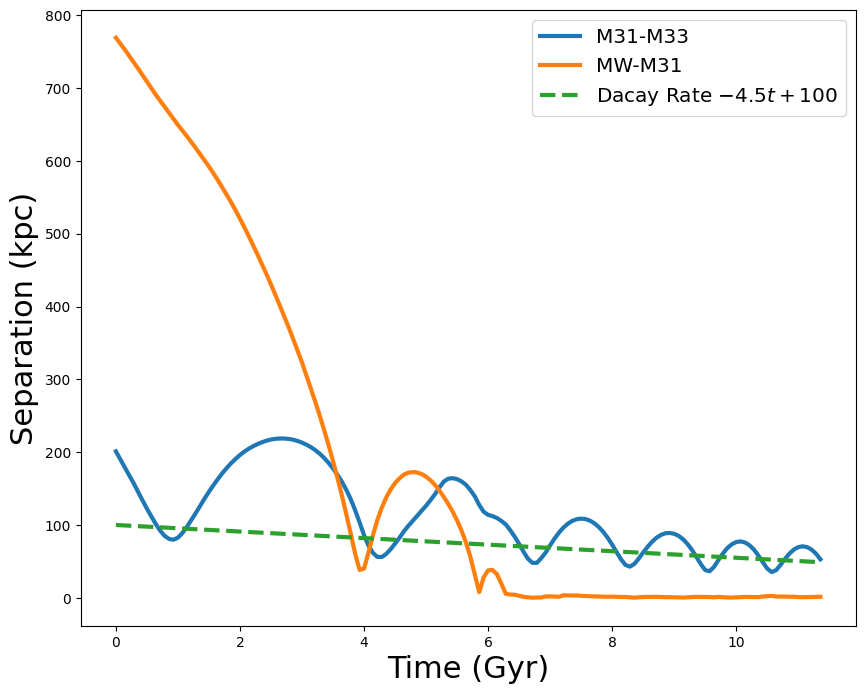

In [8]:
# Plot the Orbit of the galaxies 
#################################
time = MW_COM['t']

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(time, separation_M33_M31,
         linewidth = 3, label='M31-M33')
ax.plot(time, separation_MW_M31,
         linewidth = 3, label='MW-M31')
ax.plot(time, time*(-4.5) + 100, '--', lw=3, label=r'Dacay Rate $-4.5t+100$')
    
# Axes labels 
ax.set_xlabel('Time (Gyr)', fontsize=22) 
ax.set_ylabel('Separation (kpc)', fontsize=22)

# Legend
ax.legend(loc='upper right', fontsize='x-large')

# save the file 
plt.savefig('Separation.png')


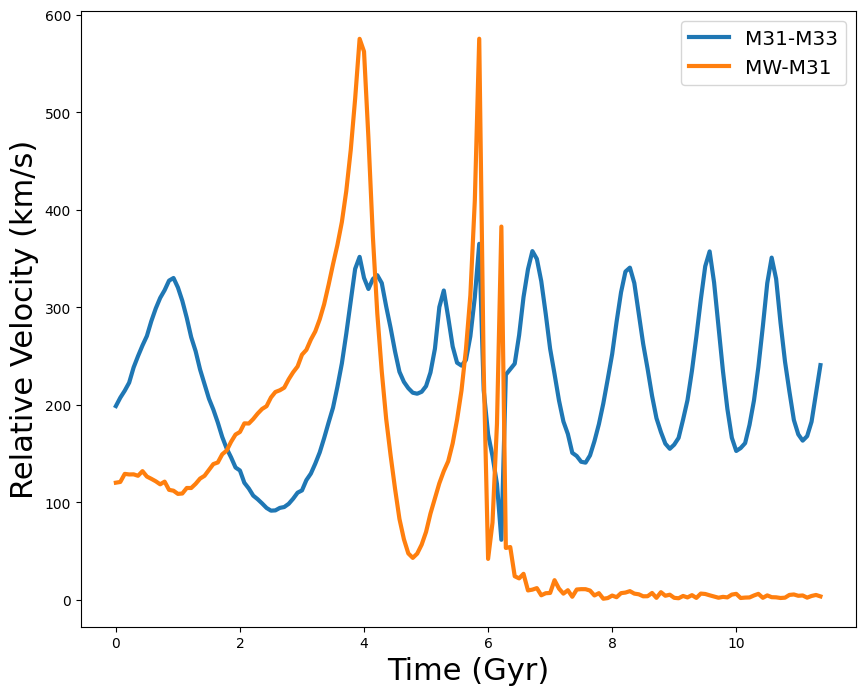

In [9]:
# Plot the orbital velocities of the galaxies 
#################################
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(time, relativevel_M33_M31,
            linewidth = 3, label='M31-M33')
ax.plot(time, relativevel_MW_M31,
            linewidth = 3, label='MW-M31')

# Axes labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Relative Velocity (km/s)', fontsize=22)

# Legend
ax.legend(loc='upper right', fontsize='x-large')

# Save the file
plt.savefig('RelativeVelocity.png')


## Questions
    1. How many close encounters will the MW and M31 experience in the future?

Two times, once during 4Gyr and then again during 5.9 Gyr.

    2. How is the time evolution of the separation and relative velocity related?

The smaller the separation, the faster the relative velocity. It make sense as the galaxies approaches closer to each other, the deeper the potential field gets and force gets stronger.

    3. When do M31 and the MW merge? (you might need to zoom in on the plot - try a log y axis). What happens to M33’s orbit when they merge?

In 6.1 Gyrs. M33 orbits around MW-M31 combined system and decays slowly.

    BONUS: what is roughly the decay rate of M33’s orbit after 6 Gyr (ratio of the differ- ence between two successive apocenters and the orbital period; you don’t need to be precise). If this rate is constant, how long will it take M33 to merge with the combined MW+M31 remnant if it is at a distance of 75 kpc?

The decay rate is about 4.5 kpc/Gyr and it will merge in 16.7 Gyr after M31-MW merges.
